In [2]:
! pip install plotly
! pip install networkx
! pip install dash

In [128]:
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Network Analysis graph for the books using Gephi

### 1. Network graph from the 1st book
<img src="network1.png" style="width: 550px"/>

### Centralities from the 1st book 
<img src="centralities1.png" style="width: 550px"/>

### 2. Network graph from the 2nd book
<img src="network2.png" style="width: 550px"/>

### Centralities from the 2nd book
<img src="centralities2.png" style="width: 550px"/>

### 3. Network graph from the 3rd book
<img src="network3.png" style="width: 550px"/>

### Centralities from the 3rd book
<img src="centralities3.png" style="width: 550px"/>

### 4-5. Network graph from the 4th and 5th book
<img src="network45.png" style="width: 550px"/>

### Centralities from the 4th and 5th book
<img src="centralities45.png" style="width: 550px"/>

### All. Network graph from all the books
<img src="networkAll.png" style="width: 550px"/>

### Centralities from all the books
<img src="centralitiesAll.png" style="width: 550px"/>

 

In [15]:
books = []
for i in range(5):
    books.append(pd.read_csv('book{}-edges.csv'.format(i+1)))

In [17]:
all_books = pd.concat(books)
all_books.head()

Source              Target        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0

### Now, sum all the books into a single edge between characters

In [19]:
edges = all_books.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()

In [21]:
edges.sort_values('weight',ascending=False).head()

Source            Target  weight
1334       Eddard-Stark  Robert-Baratheon     334
2031           Jon-Snow     Samwell-Tarly     228
1965  Joffrey-Baratheon       Sansa-Stark     222
1972  Joffrey-Baratheon  Tyrion-Lannister     219
640          Bran-Stark             Hodor     209

In [22]:
GOT = nx.from_pandas_edgelist(edges, 
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [25]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))
max_degree = max(weighted_degrees.values())

In [26]:
import seaborn as sns

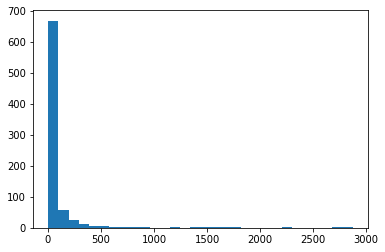

In [29]:
h = plt.hist(weighted_degrees.values(), bins = 30)

### Let's focus on the subnetwork of the key characters:

In [30]:
subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])

In [33]:
print(nx.info(subG))

Name: 
Type: Graph
Number of nodes: 63
Number of edges: 496
Average degree:  15.7460


In [40]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

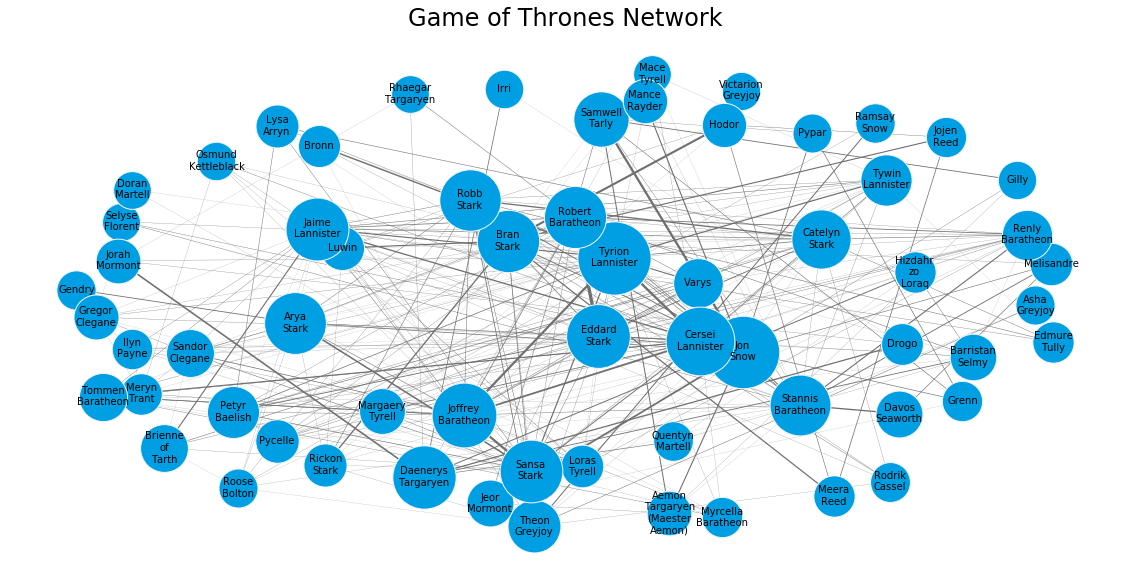

In [43]:
plt.axis('off')
plt.title('Game of Thrones Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

In [45]:
infection_times = {}

### Simulate independent cascade:

In [46]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [126]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Game of Thrones Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#ff0000')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


### Suppose Bran and Sam told Jon a secret. So let's see who will find out about it?

In [123]:
infection_times = {'Bran-Stark':-1,'Samwell-Tarly':-1,'Jon-Snow':0}

#### ->In the below figures, the items in Red are infected so it means they know the secret
#### ->And they all are in sequence as the secret passes through the characters

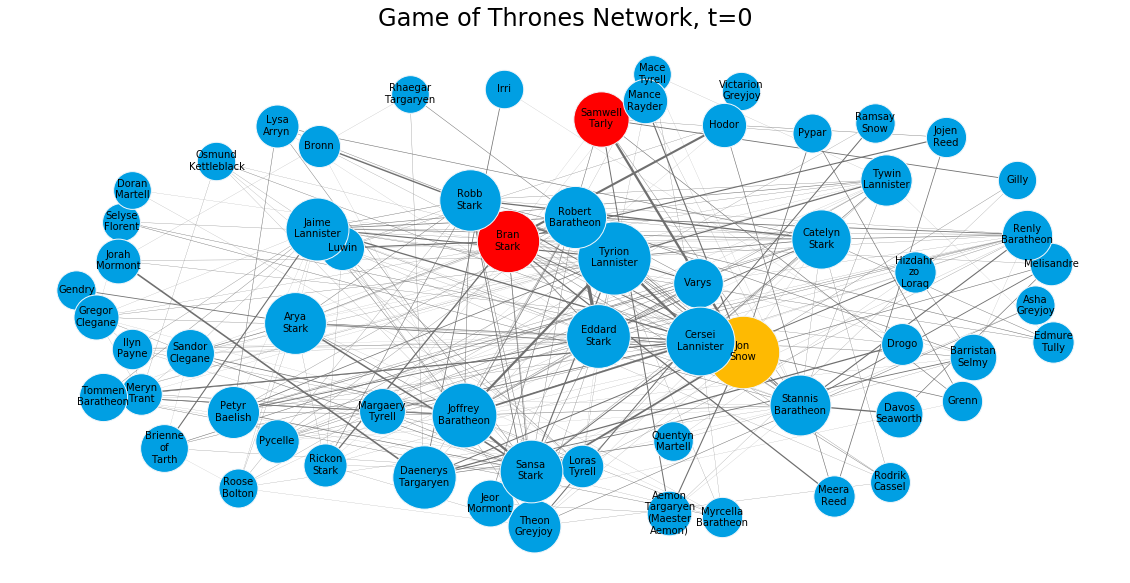

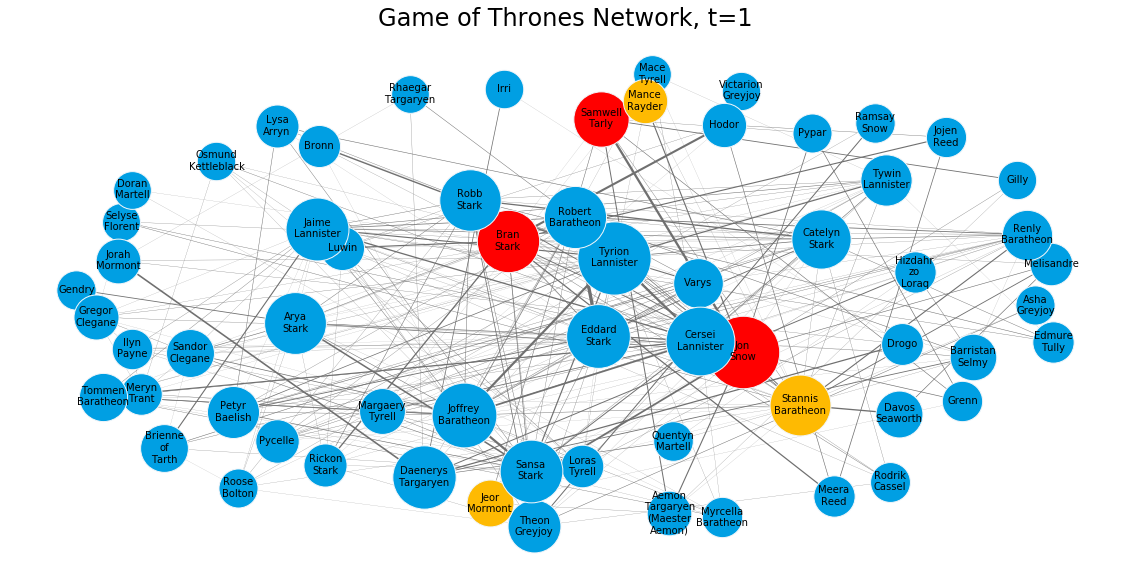

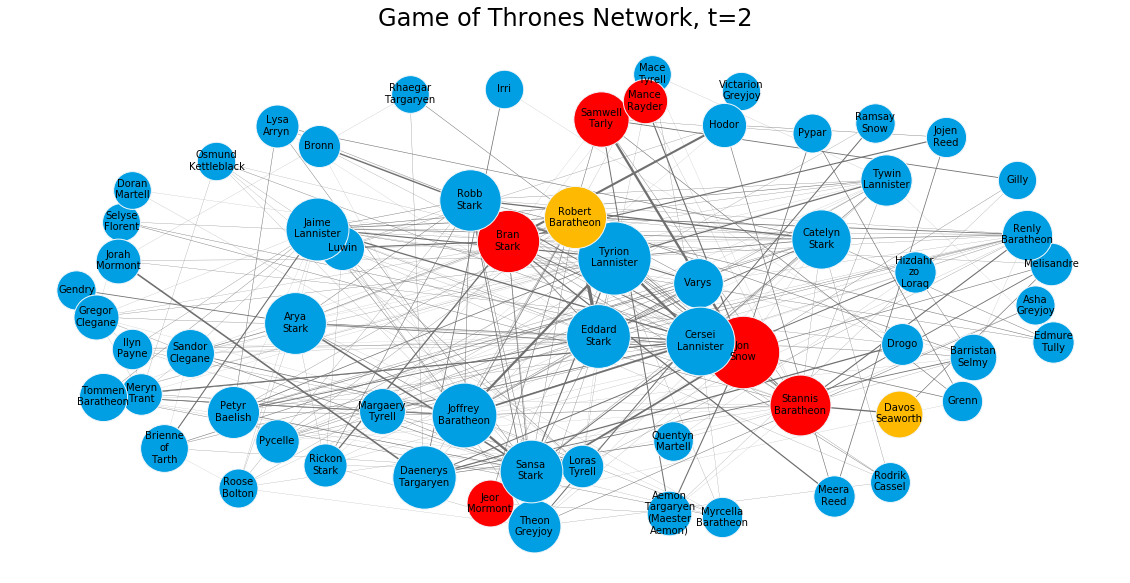

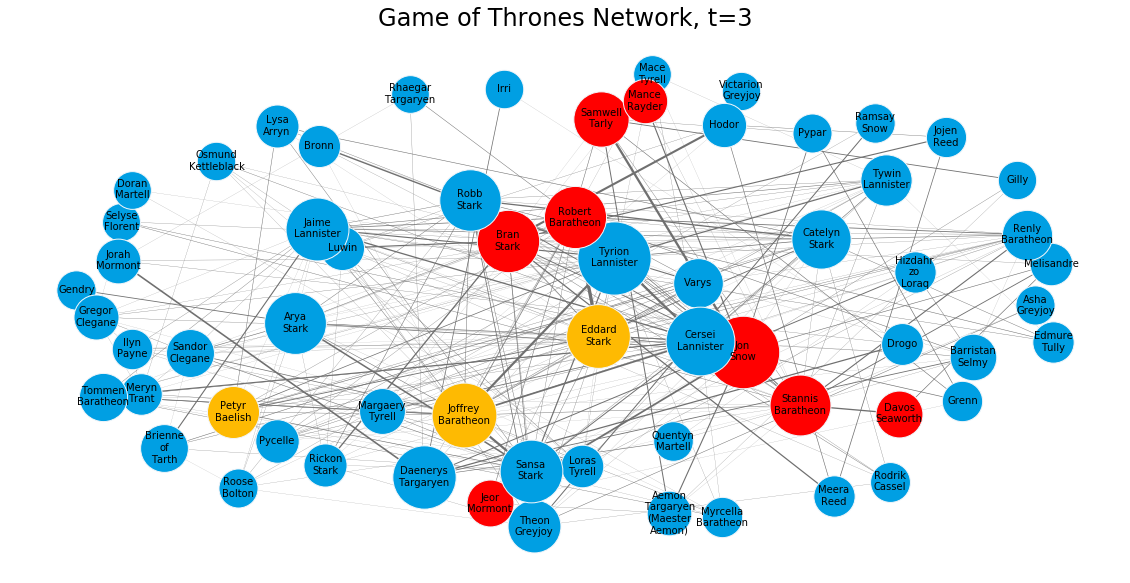

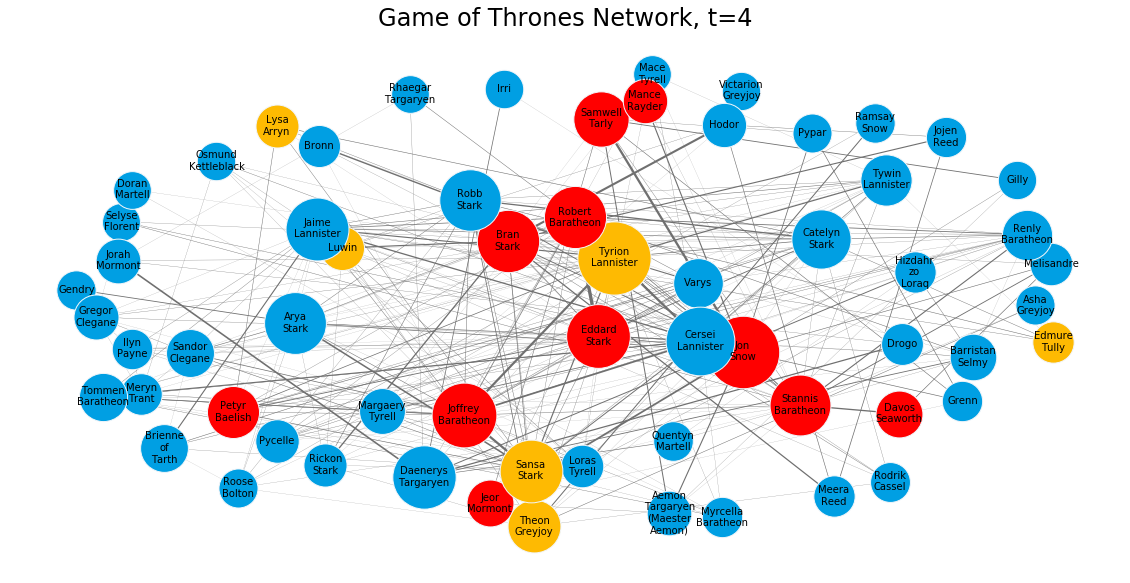

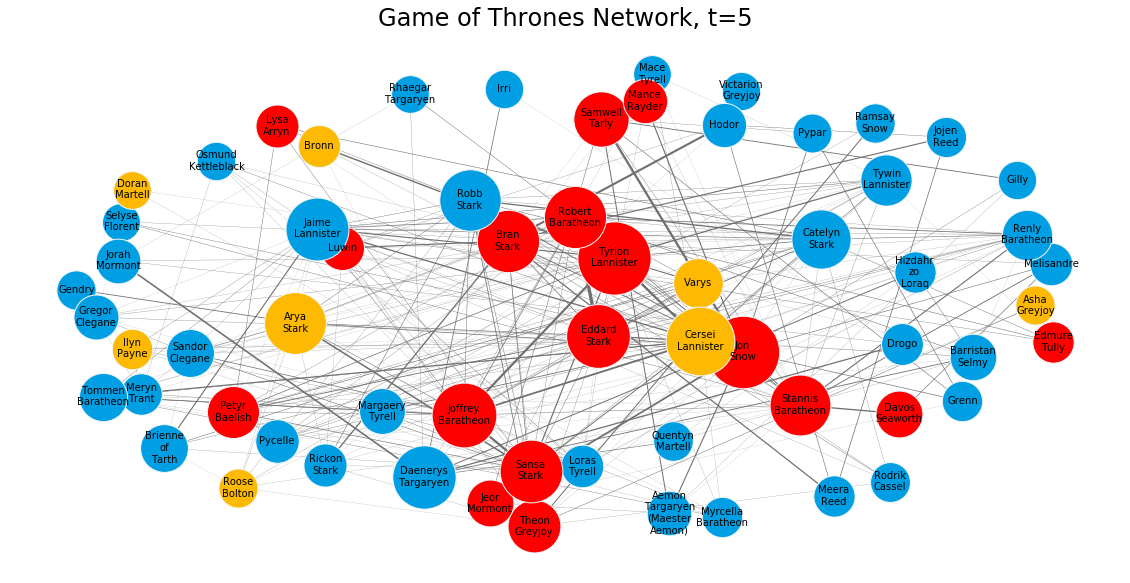

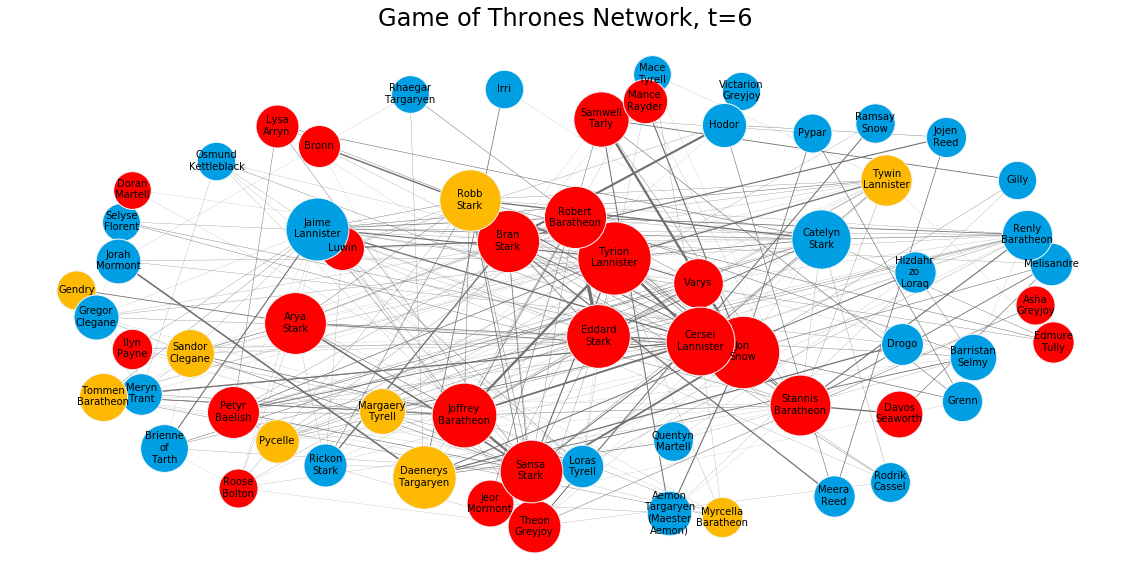

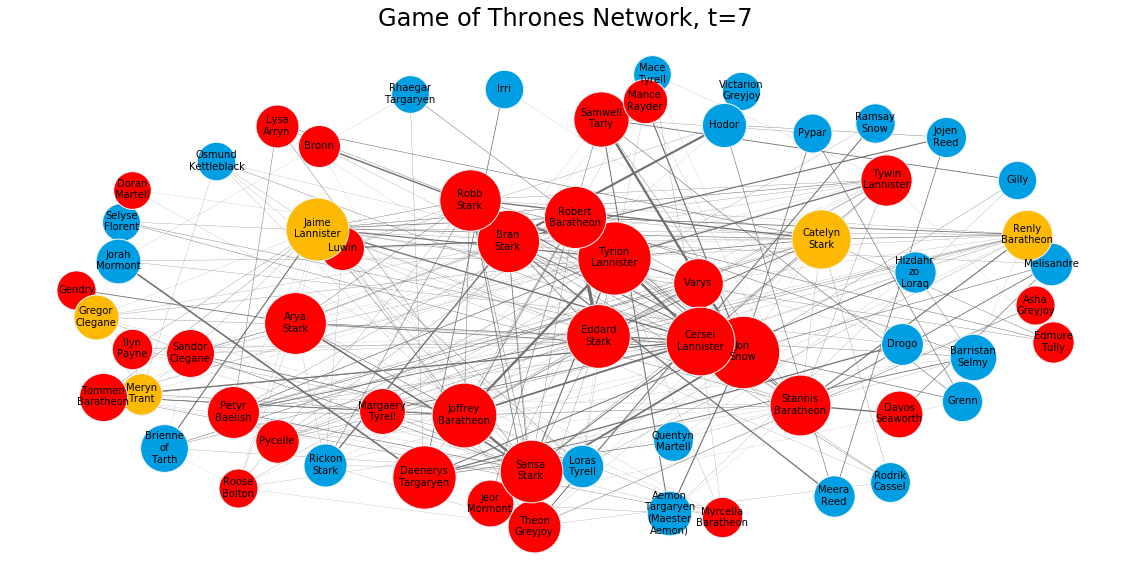

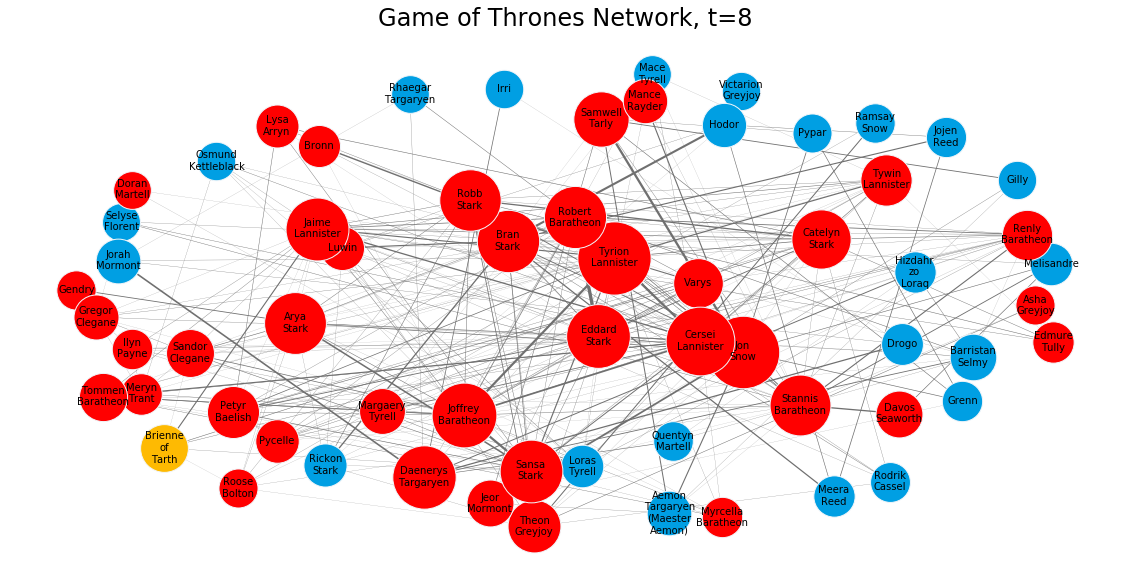

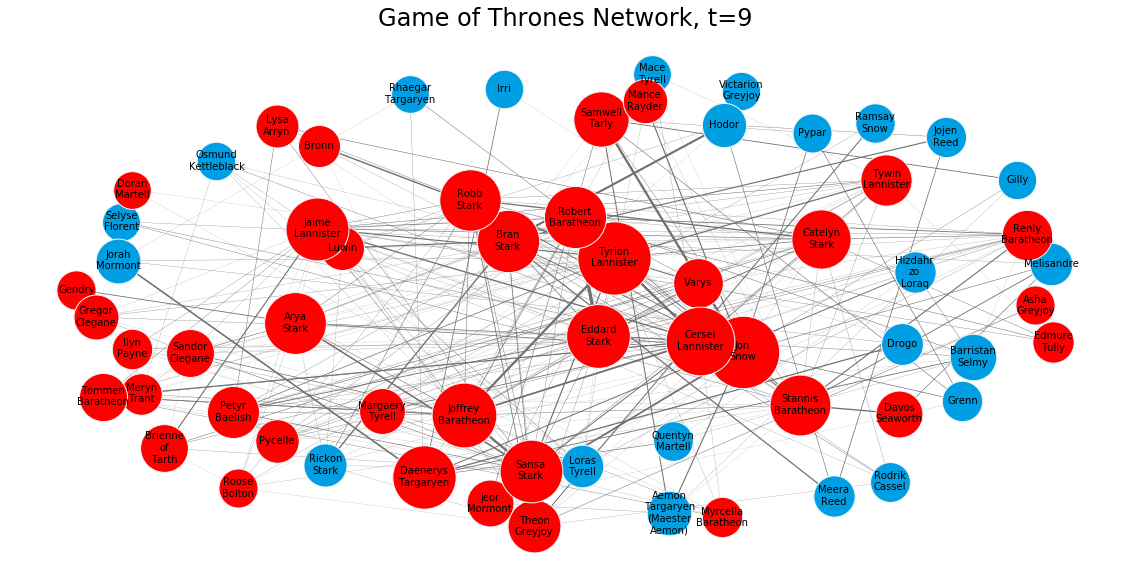

In [129]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

### Let's identify infuencers in the Network

In [55]:
top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(subG,weight='weight')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [56]:
top.head()


Degree  Weighted Degree  PageRank  Betweenness
Tyrion-Lannister       40             1842  0.052710     0.036445
Robert-Baratheon       37             1271  0.037012     0.223912
Joffrey-Baratheon      35             1518  0.042829     0.033051
Eddard-Stark           34             1330  0.037789     0.024061
Cersei-Lannister       34             1627  0.046179     0.004671

In [57]:
methods = top.columns

print(nx.info(subG))
print(nx.info(GOT))

Name: 
Type: Graph
Number of nodes: 63
Number of edges: 496
Average degree:  15.7460
Name: 
Type: Graph
Number of nodes: 796
Number of edges: 2823
Average degree:   7.0930


### For different budgets lets compare the centrality metrics for seeding


In [ ]:
max_budget = len(subG.nodes())
trials = 50
all_results = []
for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget':budget}
    for method in methods:
        infections = []
        for i in range(trials):
            infected = 0
            t= 0
            infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
            while len(infection_times)>infected:
                #t+=1
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t+=1
            infections.append(infected)
        results[method] = np.round(np.mean(infections)/len(subG.nodes()),2)

    all_results.append(results)
              

In [68]:
res_df.index = res_df.index/len(subG.nodes())

In [69]:
res_df.head()

Degree  Weighted Degree  PageRank  Betweenness
budget                                                  
0.000000    0.00             0.00      0.00         0.00
0.000252    0.50             0.53      0.52         0.48
0.000504    0.51             0.49      0.55         0.54
0.000756    0.50             0.50      0.53         0.53
0.001008    0.50             0.52      0.52         0.54

### Now let's compare the methods on a plot

Text(0.5, 0, 'Seeding Budget (out of graph size)')

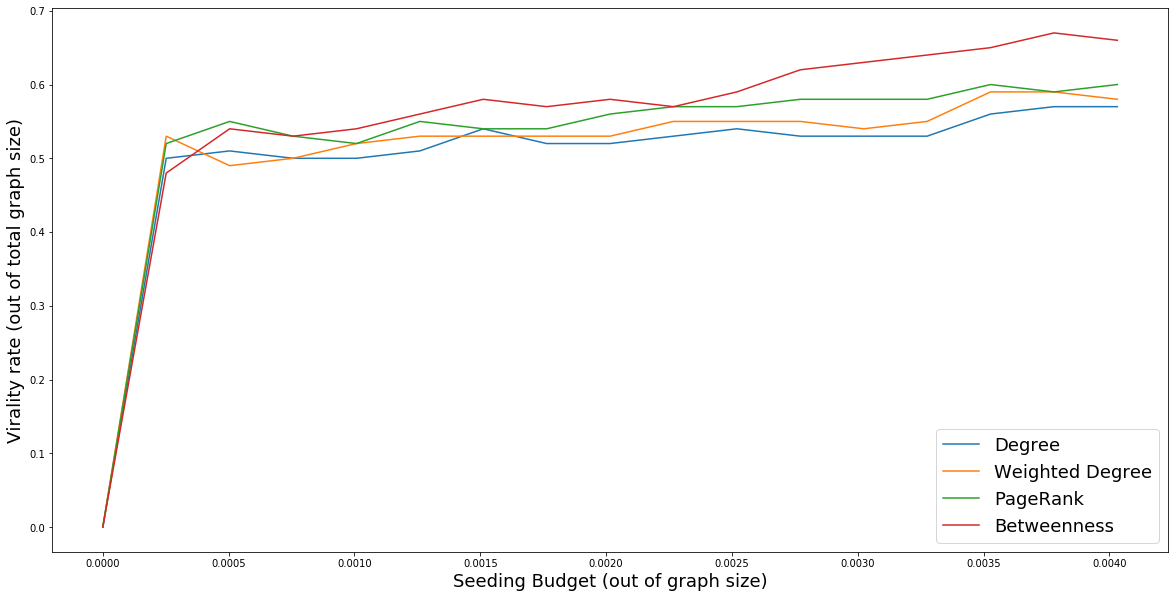

In [70]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)

### Let's find the best couple by bruteforce search

In [76]:
from itertools import product

budget=2

seed_sets = list(product(*[subG.nodes()]*budget))

print(len(seed_sets),'Seeding options')

3969 Seeding options


In [ ]:
budget = 2
trials = 20
all_results = []
results = {'budget':budget}
for seed in tqdm.tqdm_notebook(seed_sets[:]):
    infections = []
    for i in range(trials):
        infected = 0
        t= 0
        infection_times = {n:0 for n in seed}
        while len(infection_times)>infected:
            #t+=1
            infected = len(infection_times)
            infection_times = independent_cascade(subG,t,infection_times)
            t+=1
        infections.append(infected)
    results[seed] = np.round(np.mean(infections)/len(subG.nodes()),2)

all_results.append(results)

In [79]:
sorted(results.items(), key = lambda x: x[1], reverse=True)[:10]

[('budget', 2),
 (('Barristan-Selmy', 'Tyrion-Lannister'), 0.57),
 (('Tywin-Lannister', 'Samwell-Tarly'), 0.55),
 (('Tywin-Lannister', 'Tyrion-Lannister'), 0.55),
 (('Varys', 'Tywin-Lannister'), 0.54),
 (('Myrcella-Baratheon', 'Arya-Stark'), 0.54),
 (('Tywin-Lannister', 'Sansa-Stark'), 0.54),
 (('Varys', 'Bran-Stark'), 0.53),
 (('Varys', 'Tyrion-Lannister'), 0.53),
 (('Varys', 'Eddard-Stark'), 0.53)]

# Now let's do some analysis on the topics suggested in the Hackathon

In [80]:
book1 = pd.read_csv("book1.csv")

In [8]:
book1

Source              Target        Type  Weight  \
0                     Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                     Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                  Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                  Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4    Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   
..                               ...                 ...         ...     ...   
679                 Tyrion-Lannister         Willis-Wode  Undirected       4   
680                 Tyrion-Lannister               Yoren  Undirected      10   
681                  Tywin-Lannister               Varys  Undirected       4   
682                  Tywin-Lannister         Walder-Frey  Undirected       8   
683                     Waymar-Royce     Will-(prologue)  Undirected      18   

     book                               Id  
0       1                   Addam-Marbrand  
1       1                   Addam-Marbrand  
2       1                Aegon-I-Targaryen  
3       1                Aegon-I-Targaryen  
4       1  Aemon-Targaryen-(Maester-Aemon)  
..    ...                              ...  
679     1                 Tyrion-Lannister  
680     1                 Tyrion-Lannister  
681     1                  Tywin-Lannister  
682     1                  Tywin-Lannister  
683     1                     Waymar-Royce  

[684 rows x 6 columns]

In [9]:
book1Graph = nx.Graph()

In [10]:
for _, edge in book1.iterrows():
    book1Graph.add_edge(edge['Source'], edge['Target'], weight=edge['Weight'])

In [11]:
allBooks = [book1Graph]

bookNames = ['book2.csv', 'book3.csv', 'book4.csv', 'book5.csv']
for bookName in bookNames:
    book = pd.read_csv(bookName)
    GBook = nx.Graph()
    for _, edge in book.iterrows():
        GBook.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])
    allBooks.append(GBook)

## Measuring the importance of a node in a network by looking at the number of neighbors it has, that is, the number of nodes it is connected to with the help of degree of centrality

In [12]:
degOfCentrality = []
# degOfCentrailtySorted = []
# i = 0

for book in allBooks:
    degocen = nx.degree_centrality(book)
    degOfCentrality.append(degocen)

In [110]:
i = 1
for degOfOneBook in degOfCentrality:
    degOfOneBookSorted =  sorted(degOfOneBook.items(), key=lambda x:x[1], reverse=True)[0:10]
    print("Book: {}".format(i))
    i+=1
    print(degOfOneBookSorted)
    print("\n")

Book: 1
[('Eddard-Stark', 0.3548387096774194), ('Robert-Baratheon', 0.2688172043010753), ('Tyrion-Lannister', 0.24731182795698928), ('Catelyn-Stark', 0.23118279569892475), ('Jon-Snow', 0.19892473118279572), ('Robb-Stark', 0.18817204301075272), ('Sansa-Stark', 0.18817204301075272), ('Bran-Stark', 0.17204301075268819), ('Cersei-Lannister', 0.16129032258064518), ('Joffrey-Baratheon', 0.16129032258064518)]


Book: 2
[('Tyrion-Lannister', 0.2054263565891473), ('Joffrey-Baratheon', 0.1821705426356589), ('Cersei-Lannister', 0.16666666666666666), ('Arya-Stark', 0.15503875968992248), ('Stannis-Baratheon', 0.1434108527131783), ('Robb-Stark', 0.13565891472868216), ('Catelyn-Stark', 0.12790697674418605), ('Theon-Greyjoy', 0.12403100775193798), ('Renly-Baratheon', 0.12015503875968991), ('Bran-Stark', 0.11627906976744186)]


Book: 3
[('Tyrion-Lannister', 0.19536423841059603), ('Jon-Snow', 0.17218543046357615), ('Joffrey-Baratheon', 0.16556291390728478), ('Robb-Stark', 0.16225165562913907), ('Sansa-S

## The evolution of character importance
<p>According to degree centrality, the most important character in the first book is Eddard Stark but he is not even in the top 10 of the fifth book. The importance of characters changes over the course of five books because, you know, stuff happens... ;)</p>
<p>Let's look at the evolution of degree centrality of a couple of characters like Eddard Stark, Jon Snow, and Tyrion, which showed up in the top 10 of degree centrality in the first book.</p>

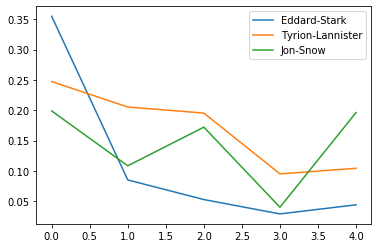

In [91]:
%matplotlib inline

# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in allBooks]
 
# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of Eddard-Stark, Tyrion-Lannister and Jon-Snow
degree_evol_df[['Eddard-Stark', 'Tyrion-Lannister', 'Jon-Snow']].plot()

## What's up with Stannis Baratheon?
<p>We can see that the importance of Eddard Stark dies off as the book series progresses. With Jon Snow, there is a drop in the fourth book but a sudden rise in the fifth book.</p>
<p>Now let's look at various other measures like <em>betweenness centrality</em> and <em>PageRank</em> to find important characters in our Game of Thrones character co-occurrence network and see if we can uncover some more interesting facts about this network. Let's plot the evolution of betweenness centrality of this network over the five books. We will take the evolution of the top four characters of every book and plot it.</p>

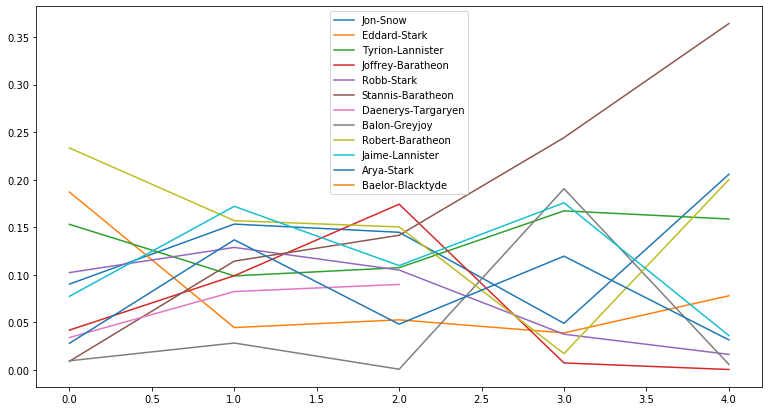

In [94]:
# Creating a list of betweenness centrality of all the books just like we did for degree centrality
evol = [nx.betweenness_centrality(book, weight='weight') for book in allBooks]

# Making a DataFrame from the list
betweenness_evol_df = pd.DataFrame.from_records(evol)

# Finding the top 4 characters in every book
set_of_char = set()
for i in range(5):
    set_of_char |= set(list(betweenness_evol_df.T[i].sort_values(ascending=False)[0:4].index))
list_of_char = list(set_of_char)

# Plotting the evolution of the top characters
betweenness_evol_df[list_of_char].plot(figsize=(13, 7))

## What does Google PageRank tell us about GoT?
<p>We see a peculiar rise in the importance of Stannis Baratheon over the books. In the fifth book, he is significantly more important than other characters in the network, even though he is the third most important character according to degree centrality.</p>
<p>PageRank was the initial way Google ranked web pages. It evaluates the inlinks and outlinks of webpages in the world wide web, which is, essentially, a directed network. Let's look at the importance of characters in the Game of Thrones network according to PageRank. </p>

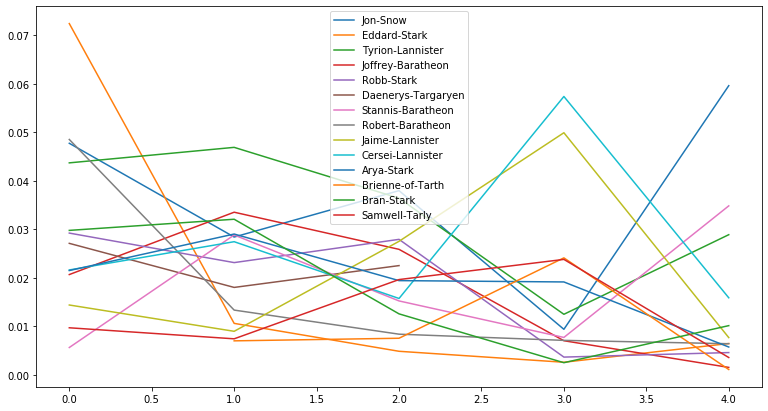

In [96]:
# Creating a list of pagerank of all the characters in all the books
evol = [nx.pagerank(book) for book in allBooks]

# Making a DataFrame from the list
pagerank_evol_df = pd.DataFrame.from_records(evol)

# Finding the top 4 characters in every book
set_of_char = set()
for i in range(5):
    set_of_char |= set(list(pagerank_evol_df.T[i].sort_values(ascending=False)[0:4].index))
list_of_char = list(set_of_char)

# Plotting the top characters
pagerank_evol_df[list_of_char].plot(figsize=(13, 7))

##  Correlation between different measures
<p>Stannis, Jon Snow, and Daenerys are the most important characters in the all the books according to PageRank. Eddard Stark follows a similar curve but for degree centrality and betweenness centrality: He is important in the first book but dies into oblivion over the book series.</p>
<p>We have seen three different measures to calculate the importance of a node in a network, and all of them tells us something about the characters and their importance in the co-occurrence network. We see some names pop up in all three measures so maybe there is a strong correlation between them?</p>
<p>Let's look at the correlation between PageRank, betweenness centrality and degree centrality for all the books using Pearson correlation.</p>

In [119]:
# Creating a list of pagerank, betweenness centrality, degree centrality
# of all the characters in all books.
allMeasures = []
allCorr = []
print("Correlation between PageRank, betweenness centrality and degree centrality")
for i in range(5):
    measures = [nx.pagerank(allBooks[i]), 
                nx.betweenness_centrality(allBooks[i], weight='weight'), 
                nx.degree_centrality(allBooks[i])]
    allMeasures.append(measures)

    # Creating the correlation DataFrame
    cor = pd.DataFrame.from_records(measures)
    # Calculating the correlation
    cor.T.corr()
    allCorr.append(cor)
    
for i in range(5):
    print("CooreBook: {}".format(i + 1))
    print(allCorr[i].T.corr())
    print("\n")

Correlation between PageRank, betweenness centrality and degree centrality
CooreBook: 1
          0         1         2
0  1.000000  0.870210  0.949258
1  0.870210  1.000000  0.871385
2  0.949258  0.871385  1.000000


CooreBook: 2
          0         1         2
0  1.000000  0.796071  0.946047
1  0.796071  1.000000  0.824200
2  0.946047  0.824200  1.000000


CooreBook: 3
          0         1         2
0  1.000000  0.822604  0.955832
1  0.822604  1.000000  0.841844
2  0.955832  0.841844  1.000000


CooreBook: 4
          0         1         2
0  1.000000  0.656856  0.946802
1  0.656856  1.000000  0.720553
2  0.946802  0.720553  1.000000


CooreBook: 5
          0         1         2
0  1.000000  0.793372  0.971493
1  0.793372  1.000000  0.833816
2  0.971493  0.833816  1.000000




## Conclusion
<p>We see a high correlation between these three measures for our character co-occurrence network.</p>
<p>So we've been looking at different ways to find the important characters in the Game of Thrones co-occurrence network. According to degree centrality, Eddard Stark is the most important character initially in the books. But who is/are the most important character(s) in the fifth book according to these three measures? </p>

 

In [120]:
# Finding the most important character in all the books,  
# according to degree centrality, betweenness centrality and pagerank.
for i in range(5):
    print("Important charactesr in Book: {}".format(i + 1))
    p_rank, b_cent, d_cent = allCorr[i].idxmax(axis=1)
    # Printing out the top character accoding to the three measures
    print("Page Rank: ", p_rank, "\nBetweenness Centarlity: ", b_cent, "\nDegree Centrality: ", d_cent)
    print("\n")

Important charactesr in Book: 1
Page Rank:  Eddard-Stark 
Betweenness Centarlity:  Robert-Baratheon 
Degree Centrality:  Eddard-Stark


Important charactesr in Book: 2
Page Rank:  Tyrion-Lannister 
Betweenness Centarlity:  Jaime-Lannister 
Degree Centrality:  Tyrion-Lannister


Important charactesr in Book: 3
Page Rank:  Jon-Snow 
Betweenness Centarlity:  Joffrey-Baratheon 
Degree Centrality:  Tyrion-Lannister


Important charactesr in Book: 4
Page Rank:  Cersei-Lannister 
Betweenness Centarlity:  Stannis-Baratheon 
Degree Centrality:  Jaime-Lannister


Important charactesr in Book: 5
Page Rank:  Jon-Snow 
Betweenness Centarlity:  Stannis-Baratheon 
Degree Centrality:  Jon-Snow




## So, that's a wrap! I hope you liked it!

### By - Harsh Jobanputra

##### Connect me through https://harshjobanputra.ml 
##### LinkedIn: https://www.linkedin.com/in/harsh-jobanputra-0b1020179
##### GitHub: https://github.com/harsh2201
##### Instagram: https://www.instagram.com/harshjobanputra.apk/